Consider the diffusion equation:<br/>
$u_t = u_{xx}, \quad 0\le x\le 1, \quad t\ge 0$<br/>
with initial and boundary conditions<br/>
$u(x, 0) = \sin\left(\frac{1}{2}\pi x\right) + \frac{1}{2}\sin(2\pi x), \quad u(0, t) = 0, \quad u(1,t) = e^{-\pi^2 t/4}, \quad t\ge 0.$<br/>
Solve the problem using Forward Euler finite difference method with$\mu=0.5$and$\mu=0.509$


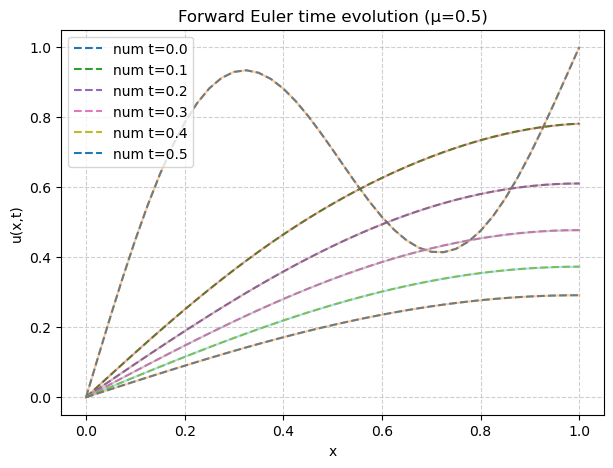

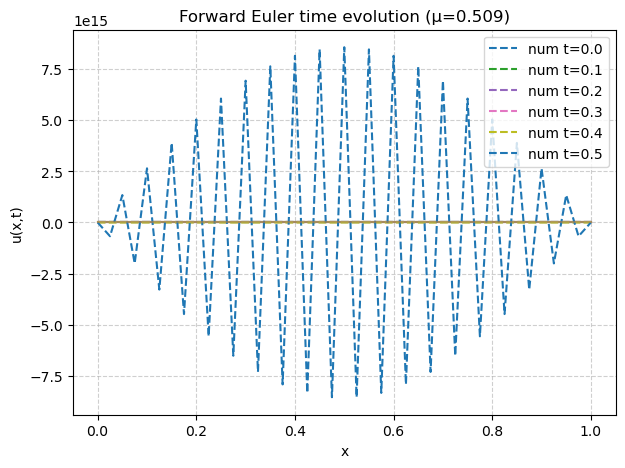

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 解析解 =====
def u_exact(x, t):
    return (np.sin(np.pi * x / 2) * np.exp(-np.pi**2 * t / 4)
            + 0.5 * np.sin(2 * np.pi * x) * np.exp(-4 * np.pi**2 * t))

# ===== Forward Euler  =====
def forward_euler_time_evolution(mu, J=40, T=0.5, record_times=None):
    dx = 1.0 / J
    dt = mu * dx**2
    Nt = int(T / dt)
    dt = T / Nt

    x = np.linspace(0, 1, J + 1)
    u = u_exact(x, 0.0)

    if record_times is None:
        record_times = [0, 0.1, 0.2, 0.3, 0.4, T]

    saved = {}
    next_t_index = 0

    for n in range(Nt+1):
        t = n * dt
        # 存需要的時間截面
        if next_t_index < len(record_times) and abs(t - record_times[next_t_index]) < dt/2:
            saved[record_times[next_t_index]] = u.copy()
            next_t_index += 1

        # FE 更新
        u_new = u.copy()
        for j in range(1, J):
            u_new[j] = u[j] + mu * (u[j+1] - 2*u[j] + u[j-1])
        u_new[0]  = 0.0
        u_new[-1] = np.exp(-np.pi**2 * t / 4)
        u = u_new

    return x, saved

# ===== 主程式：分別展示 μ=0.5 和 μ=0.509 =====
mus = [0.5, 0.509]
record_times = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for mu in mus:
    x, snapshots = forward_euler_time_evolution(mu, J=40, T=0.5, record_times=record_times)

    plt.figure(figsize=(7,5))
    for t in record_times:
        plt.plot(x, snapshots[t], "--", label=f"num t={t:.1f}")
        plt.plot(x, u_exact(x, t), "-", alpha=0.4)

    plt.title(f"Forward Euler time evolution (μ={mu})")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.grid(True, ls="--", alpha=0.6)
    plt.legend()
plt.show()


Consider the diffusion equation:<br/>
$u_t = u_{xx}, \quad 0\le x\le 1, \quad t\ge 0$<br/>
with initial and boundary conditions<br/>
$u(x, 0) = \sin\left(2\pi x\right)e^{x}, \quad u(0, t) = u(1,t) = 0, \quad t\ge 0.$<br/>
With the aid of Fast Since transform, solve the problem using (a) finite difference method and (b) method of line approach to $T=1$. Find the order of convergence.

N=  31,  CN err=3.797e-09,  MOL err=2.411e-07
N=  63,  CN err=3.797e-09,  MOL err=1.179e-07
N= 127,  CN err=3.797e-09,  MOL err=5.698e-08
N= 255,  CN err=3.797e-09,  MOL err=2.658e-08

approx order (CN)  ≈ -0.00
approx order (MOL) ≈ 1.05


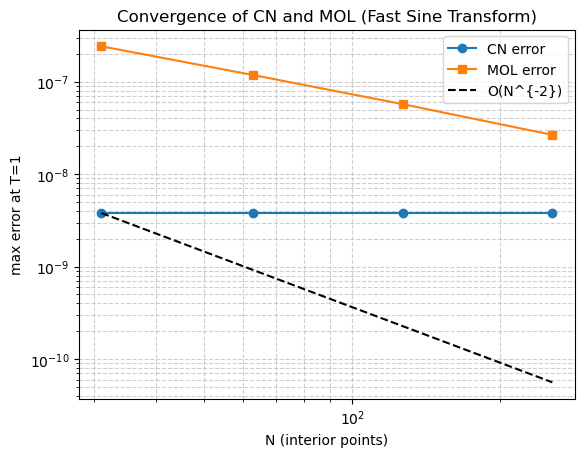

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst, idst   # Fast Sine Transform

# ===== sine transform 工具 =====
def fst(v):
    return dst(v, type=1)

def ifst(v):
    N = len(v)
    return idst(v, type=1) / (2*(N+1))

# ===== PDE 設定 =====
# u_t = u_xx, 0<x<1, t>0
# u(x,0) = sin(2πx) e^x,  u(0,t)=u(1,t)=0

def u0_fun(x):
    return np.sin(2*np.pi*x) * np.exp(x)

# ===== Laplacian eigenvalues (FD with Dirichlet) =====
def lap_eigs(N, h):
    k = np.arange(1, N+1)
    lam = -4.0 / h**2 * np.sin(0.5 * np.pi * k / (N+1))**2
    return lam

# ===== (a) Finite difference in time: Crank–Nicolson =====
def solve_CN(N, dt, T):
    h = 1.0 / (N+1)
    x_int = np.linspace(h, 1.0-h, N)   # interior 點
    u = u0_fun(x_int)

    lam = lap_eigs(N, h)
    r = 0.5 * dt
    amp = (1 + r*lam) / (1 - r*lam)    # 每個模態的放大係數

    Nt = int(T/dt)
    for _ in range(Nt):
        u_hat = fst(u)
        u_hat = amp * u_hat
        u = ifst(u_hat)
    return x_int, u

# ===== (b) Method of lines: semi-discrete exact in time =====
def solve_MOL(N, T):
    h = 1.0 / (N+1)
    x_int = np.linspace(h, 1.0-h, N)
    u0 = u0_fun(x_int)

    lam = lap_eigs(N, h)
    u0_hat = fst(u0)
    uT_hat = np.exp(lam*T) * u0_hat
    uT = ifst(uT_hat)
    return x_int, uT

# ===== 用很細的 MOL 解當「近似真解」 =====
def reference_solution(N_ref=2047, T=1.0):
    return solve_MOL(N_ref, T)

# ===== 收斂測試 =====
def convergence_test():
    T = 1.0
    Ns = [31, 63, 127, 255]   # interior 點數
    err_CN = []
    err_MOL = []

    x_ref, u_ref = reference_solution(N_ref=2047, T=T)

    for N in Ns:
        # CN
        h = 1.0 / (N+1)
        dt = 0.2 * h**2      # 時間步，讓時間誤差比空間更小
        x_CN, u_CN = solve_CN(N, dt, T)

        # MOL
        x_M, u_M = solve_MOL(N, T)

        # 參考解插值到對應網格
        u_ref_CN = np.interp(x_CN, x_ref, u_ref)
        u_ref_M  = np.interp(x_M,  x_ref, u_ref)

        err1 = np.max(np.abs(u_CN - u_ref_CN))
        err2 = np.max(np.abs(u_M  - u_ref_M))

        err_CN.append(err1)
        err_MOL.append(err2)

        print(f"N={N:4d},  CN err={err1:.3e},  MOL err={err2:.3e}")

    Ns_arr = np.array(Ns, dtype=float)
    p_CN  = np.polyfit(np.log(Ns_arr), np.log(err_CN), 1)[0]
    p_MOL = np.polyfit(np.log(Ns_arr), np.log(err_MOL), 1)[0]
    print(f"\napprox order (CN)  ≈ {-p_CN:.2f}")
    print(f"approx order (MOL) ≈ {-p_MOL:.2f}")

    # 誤差圖
    plt.figure()
    plt.loglog(Ns_arr, err_CN, 'o-', label='CN error')
    plt.loglog(Ns_arr, err_MOL, 's-', label='MOL error')
    plt.loglog(Ns_arr, err_CN[0]*(Ns_arr/Ns_arr[0])**(-2),
               'k--', label='O(N^{-2})')
    plt.xlabel("N (interior points)")
    plt.ylabel("max error at T=1")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.title("Convergence of CN and MOL (Fast Sine Transform)")
    plt.show()

if __name__ == "__main__":
    convergence_test()
